In [1]:
import os
# Set environment variable to suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from src.loading_data.get_data import load_cv_data
from src.cnn_emos.nn_forecast import CNNEMOS, CNNBaggingEMOS
from src.visualization.twcrpss_plot import make_twcrpss_plot
from src.visualization.brier_score import make_brier_skill_plot
from src.visualization.pit import make_cpit_diagram, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness
from src.visualization.plot_forecasts import plot_forecast_pdf_tf, plot_weight_mixture_cnns, plot_weight_mixture_bagging
from src.climatology.climatology import Climatology
from src.linreg_emos.emos import LinearEMOS
from src.loading_data.get_data import get_fold_is
from src.visualization.brier_score import make_bootstrap_brier

import sklearn

from scipy.stats import norm

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import optuna

### Loading all data

In [2]:
all_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in all_features}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [3]:
train_data0_original, test_data0_original, ignore = load_cv_data(0, features_names_dict)

data_load = train_data0_original.batch(32)

train_data0 = train_data0_original.batch(train_data0_original.cardinality())
test_data0 = test_data0_original.batch(test_data0_original.cardinality())

In [4]:
train_data1, test_data1_original, ignore = load_cv_data(1, features_names_dict)

train_data1 = train_data1.batch(train_data1.cardinality())

test_data1 = test_data1_original.batch(test_data1_original.cardinality())


train_data2, test_data2_original, ignore = load_cv_data(2, features_names_dict)

train_data2 = train_data2.batch(train_data2.cardinality())

test_data2 = test_data2_original.batch(test_data2_original.cardinality())


train_data3, test_data3_original, ignore = load_cv_data(3, features_names_dict)

train_data3 = train_data3.batch(train_data3.cardinality())

test_data3 = test_data3_original.batch(test_data3_original.cardinality())

### Loading Climatology

In [5]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/climatology/climatology_cv_0'

climatology = Climatology.load(folder)

### Loading All Linear Models

In [6]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base'

with open(filepath, 'rb') as f:
    constant_weight_tn = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme'

with open(filepath, 'rb') as f:
    sharp_sigmoid_weight_tn = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate'

with open(filepath, 'rb') as f:
    sigmoid_weight_am_tn_ln = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_cnn_weight'

with open(filepath, 'rb') as f:
    best_cnn_weight_tn = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ml_tn_ln_cnn_weight'

with open(filepath, 'rb')as f:
    best_cnn_weight_am_tn_ln = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_indictor_weight'

with open(filepath, 'rb') as f:
    indicator_weight_tn = LinearEMOS(pickle.load(f))



filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ln_indictor_weight'

with open(filepath, 'rb') as f:
    indicator_weight_ln = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ln_crps'

with open(filepath, 'rb') as f:
    constant_weight_ln = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_gev_indictor_weight'

with open(filepath, 'rb') as f:
    indicator_weight_gev = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_gev_crps'

with open(filepath, 'rb') as f:
    constant_weight_gev = LinearEMOS(pickle.load(f))

all_linear_models_fold0 = {'LinEMOS Constant Weight TN': constant_weight_tn,
                           'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln,
                           'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn,
                           'LinEMOS Best CNN Weight TN': best_cnn_weight_tn,
                           'LinEMOS Indicator Weight TN': indicator_weight_tn}

all_linear_models_without_constant_weight0  = {'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln,
                                            'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn,
                                            'LinEMOS Best CNN Weight TN': best_cnn_weight_tn,
                                            'LinEMOS Indicator Weight TN': indicator_weight_tn}

linear_models_different_distribution = {'LinEMOS Indicator Weight': indicator_weight_tn,
                                        'LinEMOS Constant Weight LN': constant_weight_ln,
                                        'LinEMOS Indicator Weight LN': indicator_weight_ln,
                                        'LinEMOS Constant Weight GEV': constant_weight_gev,
                                        'LinEMOS Indicator Weight GEV': indicator_weight_gev
}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given parameters for Log Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution


In [7]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_indictor_weight_8'

with open(filepath, 'rb') as f:
    indicator_weight8_tn = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_indictor_weight_10'

with open(filepath, 'rb') as f:
    indicator_weight10_tn = LinearEMOS(pickle.load(f))

# filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_indictor_weight_14'

# with open(filepath, 'rb') as f:
#     indicator_weight14_tn = LinearEMOS(pickle.load(f))

all_indicator_weight_models = {"LinEMOS Indicator 8": indicator_weight8_tn,
                               "LinEMOS Indicator 10": indicator_weight10_tn,
                               "LinEMOS Indicator 12": indicator_weight_tn,
                               "LinEMOS Best CNN Weight": best_cnn_weight_tn}
                               #"Sharp Sigmoid Weight": sharp_sigmoid_weight_tn}
                               #"Indicator 14": indicator_weight14_tn}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution


In [8]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base1'

with open(filepath, 'rb') as f:
    constant_weight_tn1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme1'

with open(filepath, 'rb') as f:
    sharp_sigmoid_weight_tn1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate1'

with open(filepath, 'rb') as f:
    sigmoid_weight_am_tn_ln1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_cnn_weight1'

with open(filepath, 'rb') as f:
    best_cnn_weight_tn1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ml_tn_ln_cnn_weight1'

with open(filepath, 'rb')as f:
    best_cnn_weight_am_tn_ln1 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_indictor_weight1'

with open(filepath, 'rb') as f:
    indicator_weight_tn1 = LinearEMOS(pickle.load(f))

all_linear_models_fold1 = {'LinEMOS Constant Weight TN': constant_weight_tn1,
                           'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln1,
                           'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn1,
                           'LinEMOS Best CNN Weight TN': best_cnn_weight_tn1,
                           'LinEMOS Indicator Weight TN': indicator_weight_tn1}

all_linear_models_without_constant_weight1  = {'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln1,
                                            'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn1,
                                            'LinEMOS Best CNN Weight TN': best_cnn_weight_tn1,
                                            'LinEMOS Indicator Weight TN': indicator_weight_tn1}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution


In [9]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base2'

with open(filepath, 'rb') as f:
    constant_weight_tn2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme2'

with open(filepath, 'rb') as f:
    sharp_sigmoid_weight_tn2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate2'

with open(filepath, 'rb') as f:
    sigmoid_weight_am_tn_ln2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_cnn_weight2'

with open(filepath, 'rb') as f:
    best_cnn_weight_tn2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ml_tn_ln_cnn_weight2'

with open(filepath, 'rb')as f:
    best_cnn_weight_am_tn_ln2 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_indictor_weight2'

with open(filepath, 'rb') as f:
    indicator_weight_tn2 = LinearEMOS(pickle.load(f))

all_linear_models_fold2 = {'LinEMOS Constant Weight TN': constant_weight_tn2,
                           'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln2,
                           'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn2,
                           'LinEMOS Best CNN Weight TN': best_cnn_weight_tn2,
                           'LinEMOS Indicator Weight TN': indicator_weight_tn2}

all_linear_models_without_constant_weight2  = {'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln2,
                                            'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn2,
                                            'LinEMOS Best CNN Weight TN': best_cnn_weight_tn2,
                                            'LinEMOS Indicator Weight TN': indicator_weight_tn2}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution


In [10]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_base3'

with open(filepath, 'rb') as f:
    constant_weight_tn3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/extreme3'

with open(filepath, 'rb') as f:
    sharp_sigmoid_weight_tn3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/intermediate3'

with open(filepath, 'rb') as f:
    sigmoid_weight_am_tn_ln3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_cnn_weight3'

with open(filepath, 'rb') as f:
    best_cnn_weight_tn3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_ml_tn_ln_cnn_weight3'

with open(filepath, 'rb')as f:
    best_cnn_weight_am_tn_ln3 = LinearEMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/linregemos/emos_tn_indictor_weight3'

with open(filepath, 'rb') as f:
    indicator_weight_tn3 = LinearEMOS(pickle.load(f))

all_linear_models_fold3 = {'LinEMOS Constant Weight TN': constant_weight_tn3,
                           'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln3,
                           'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn3,
                           'LinEMOS Best CNN Weight TN': best_cnn_weight_tn3,
                           'LinEMOS Indicator Weight TN': indicator_weight_tn3}

all_linear_models_without_constant_weight3  = {'LinEMOS Sigmoid Weight AM TN-LN': sigmoid_weight_am_tn_ln3,
                                            'LinEMOS Sharp Sigmoid Weight TN': sharp_sigmoid_weight_tn3,
                                            'LinEMOS Best CNN Weight TN': best_cnn_weight_tn3,
                                            'LinEMOS Indicator Weight TN': indicator_weight_tn3}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Truncated Normal distribution


### Loading Single Model CNNs

In [11]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_1'

cnn_constant_weight_tn1 = CNNEMOS.my_load(filepath, data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_2'

cnn_constant_weight_tn2 = CNNEMOS.my_load(filepath, data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_3'

cnn_constant_weight_tn3 = CNNEMOS.my_load(filepath, data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_4'

cnn_constant_weight_tn4 = CNNEMOS.my_load(filepath, data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/cnnemos/crps_tn_variance_5'

cnn_constant_weight_tn5 = CNNEMOS.my_load(filepath, data_load)

single_cnn_constant_weight_dict = {
    'CNNEMOS Constant Weight TN 1': cnn_constant_weight_tn1,
    'CNNEMOS Constant Weight TN 2': cnn_constant_weight_tn2,
    'CNNEMOS Constant Weight TN 3': cnn_constant_weight_tn3,
    'CNNEMOS Constant Weight TN 4': cnn_constant_weight_tn4,
    'CNNEMOS Constant Weight TN 5': cnn_constant_weight_tn5
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


### Loading Bagging CNNs



In [12]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps'

bagging_tn_crps = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps_variance_check'

bagging_tn_crps_2 = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps_2.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps_variance_check2'

bagging_tn_crps_3 = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps_3.load_models(data_load)

bagging_tn_crps_models = {'Bagging TN CRPS 1': bagging_tn_crps,
                          'Bagging TN CRPS 2': bagging_tn_crps_2,
                          'Bagging TN CRPS 3': bagging_tn_crps_3,}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_tn'

bagging_best_cnn_weight_tn = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_mixture'

bagging_best_cnn_weight_tn_ln =  CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_ln.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/sharp_sigmoid_tn'

bagging_sharp_sigmoid_tn = CNNBaggingEMOS.my_load(filepath)
bagging_sharp_sigmoid_tn.load_models(data_load)

all_bagging_models = {'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln,
                      'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn,
                      'Bagging Constant Weight TN': bagging_tn_crps
                      }

all_bagging_models_without_constant_weight = {
                      'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln,
                      'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


In [14]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/sharp_sigmoid_tn'

bagging_indicator_weight_tn = CNNBaggingEMOS.my_load(filepath)
bagging_indicator_weight_tn.load_models(data_load)

bagging_models_science_talk = {'CNNEMOS Best CNN Weight': bagging_best_cnn_weight_tn,
                               'CNNEMOS Indicator 12 Weight': bagging_indicator_weight_tn}

all_bagging_models_science_talk = {'CNNEMOS Best CNN Weight': bagging_best_cnn_weight_tn,
                               'CNNEMOS Indicator 12 Weight': bagging_indicator_weight_tn,
                               'CNNEMOS Constant Weight': bagging_tn_crps}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


### Bagging Cross-Validation

In [7]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps_fold1'

bagging_tn_crps_f1 = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps_f1.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_tn_fold1'

bagging_best_cnn_weight_tn_f1 = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_f1.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_mixture_fold1'

bagging_best_cnn_weight_tn_ln_f1 = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_ln_f1.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/sharp_sigmoid_tn_fold1'

bagging_sharp_sigmoid_tn_f1 = CNNBaggingEMOS.my_load(filepath)
bagging_sharp_sigmoid_tn_f1.load_models(data_load)

# all_bagging_models = {'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn,
#                       'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln,
#                       'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn,
#                       'Bagging Constant Weight TN': bagging_tn_crps
#                       }

all_bagging_models_without_constant_weight_f1 = {
                      'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn_f1,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln_f1,
                      'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn_f1
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


In [8]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps_fold2'

bagging_tn_crps_f2 = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps_f2.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_tn_fold2'

bagging_best_cnn_weight_tn_f2 = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_f2.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_mixture_fold2'

bagging_best_cnn_weight_tn_ln_f2 = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_ln_f2.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/sharp_sigmoid_tn_fold2'

bagging_sharp_sigmoid_tn_f2 = CNNBaggingEMOS.my_load(filepath)
bagging_sharp_sigmoid_tn_f2.load_models(data_load)

# all_bagging_models = {'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn,
#                       'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln,
#                       'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn,
#                       'Bagging Constant Weight TN': bagging_tn_crps
#                       }

all_bagging_models_without_constant_weight_f2 = {
                      'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn_f2,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln_f2,
                      'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn_f2
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [9]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/tn_crps_fold3'

bagging_tn_crps_f3 = CNNBaggingEMOS.my_load(filepath)
bagging_tn_crps_f3.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_tn_fold3'

bagging_best_cnn_weight_tn_f3 = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_f3.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/model_87_mixture_fold3'

bagging_best_cnn_weight_tn_ln_f3 = CNNBaggingEMOS.my_load(filepath)
bagging_best_cnn_weight_tn_ln_f3.load_models(data_load)

filepath = '/net/pc200239/nobackup/users/hakvoort/models/final_models/bagging_same_data/sharp_sigmoid_tn_fold3'

bagging_sharp_sigmoid_tn_f3 = CNNBaggingEMOS.my_load(filepath)
bagging_sharp_sigmoid_tn_f3.load_models(data_load)

# all_bagging_models = {'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn,
#                       'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln,
#                       'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn,
#                       'Bagging Constant Weight TN': bagging_tn_crps
#                       }

all_bagging_models_without_constant_weight_f3 = {
                      'Bagging Best CNN Weight TN': bagging_best_cnn_weight_tn_f3,
                      'Bagging Best CNN Weight TN-LN': bagging_best_cnn_weight_tn_ln_f3,
                      'Bagging Sharp Sigmoid Weight TN': bagging_sharp_sigmoid_tn_f3
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### Weight Functions

In [16]:
x = np.linspace(0, 20, 2000)
y_intermediate = norm.cdf(x, loc=7.050563812255859, scale=2.405172109603882) + 0.06170300021767616

y_extreme = norm.cdf(x, loc=8.830960273742676, scale=1.0684260129928589) + 0.015800999477505684

y_cnn = norm.cdf(x, loc=5.42, scale=7.822) + 0.919453

y_ind12 = np.where(x > 12, 1, 0)

y_ind10 = np.where(x > 10, 1, 0)

y_ind8 = np.where(x > 8, 1, 0)

x_base = np.ones(x.shape)

### All the Weight Functions

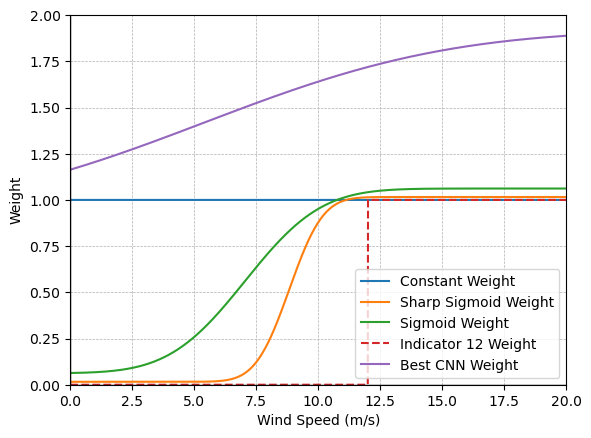

In [ ]:
plt.plot(x, x_base, label='Constant Weight')
plt.plot(x, y_extreme, label='Sharp Sigmoid Weight')
plt.plot(x, y_intermediate, label='Sigmoid Weight')
plt.plot(x, y_ind12, label='Indicator 12 Weight', linestyle='--')
plt.plot(x, y_cnn, label='Best CNN Weight')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Weight')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)
plt.xlim(0,20)
plt.ylim(0, 2)
plt.legend()
plt.show()

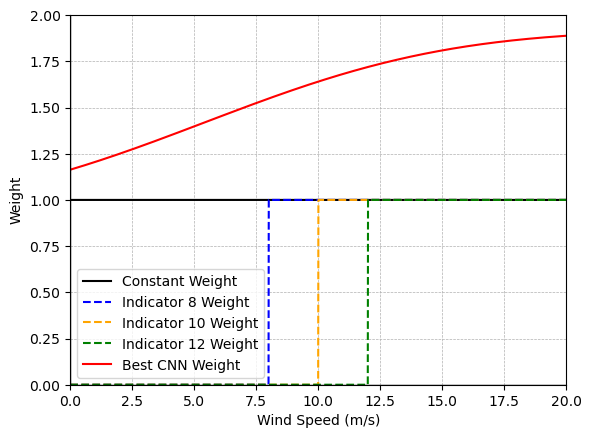

In [19]:
plt.plot(x, x_base, label='Constant Weight', color='black')
plt.plot(x, y_ind8, label='Indicator 8 Weight', linestyle='--', color='blue')
plt.plot(x, y_ind10, label='Indicator 10 Weight', linestyle='--', color='orange')
plt.plot(x, y_ind12, label='Indicator 12 Weight', linestyle='--', color='green')
plt.plot(x, y_cnn, label='Best CNN Weight', color='red')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Weight')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)
plt.xlim(0,20)
plt.ylim(0, 2)
plt.legend()
plt.show()

### Results on Test Data

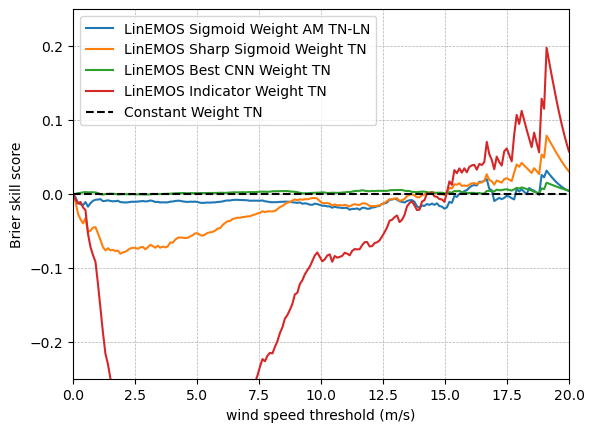

In [21]:
values = np.linspace(0,20,200)
ylim = [-0.25, 0.25]
make_brier_skill_plot(constant_weight_tn, all_linear_models_without_constant_weight0, test_data0, values, ylim=ylim, name_base_model='Constant Weight TN')

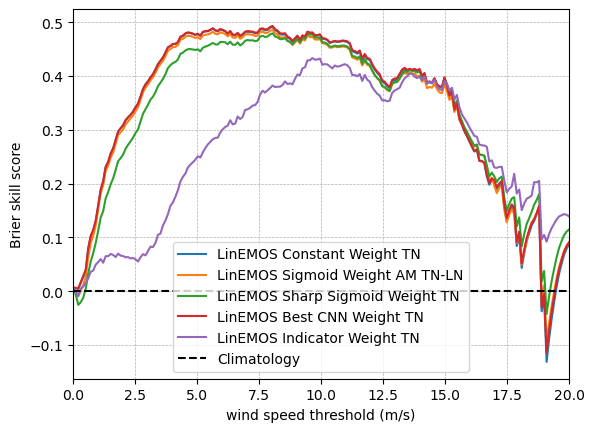

In [ ]:
values = np.linspace(0.01,20,200)
make_brier_skill_plot(climatology, all_linear_models_fold0, test_data0, values, name_base_model='Climatology')

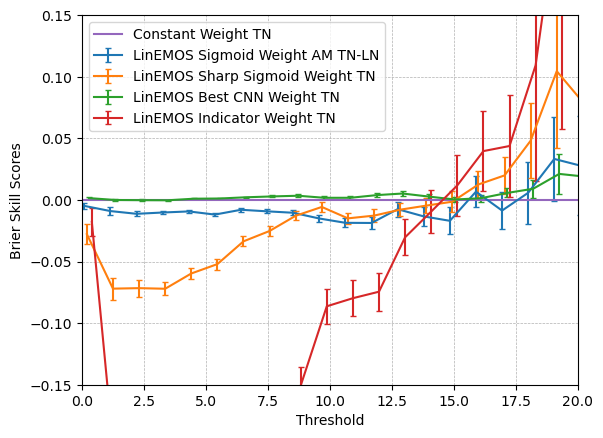

In [ ]:
values = np.linspace(0,20,20)
ylim = [-0.15,0.15]
make_bootstrap_brier(constant_weight_tn, all_linear_models_without_constant_weight0, test_data0, values,  ylim=ylim, name_base_model='Constant Weight TN', bootstrap_size=10000)

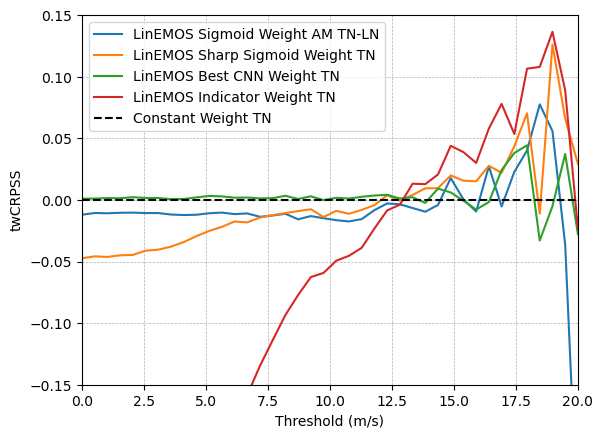

In [ ]:
values = np.linspace(0,20,40)
ylim = [-0.15,0.15]
make_twcrpss_plot(constant_weight_tn, all_linear_models_without_constant_weight0, test_data0, values, ylim=ylim, base_model_name='Constant Weight TN', sample_size=2000)

There are 8671 values in the PIT diagram


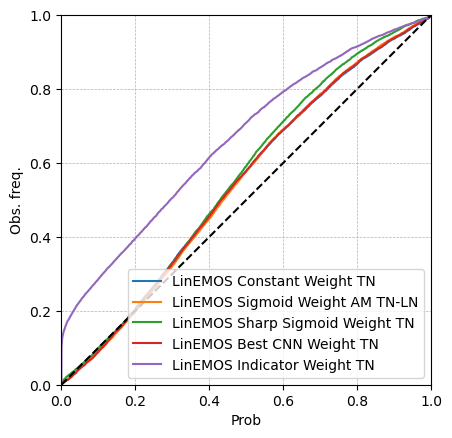

In [58]:
t = 0
make_cpit_diagram(all_linear_models_fold0, test_data0_original, t=t)

There are 265 values in the PIT diagram


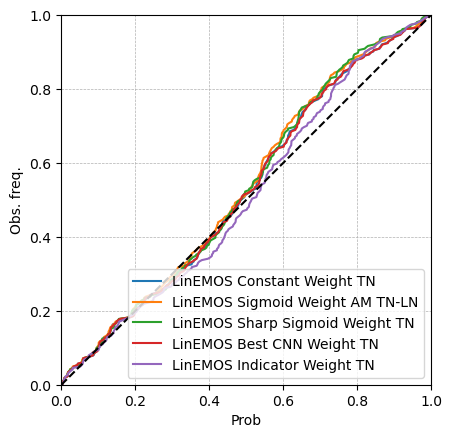

In [68]:
t = 12
make_cpit_diagram(all_linear_models_fold0, test_data0_original, t=t)

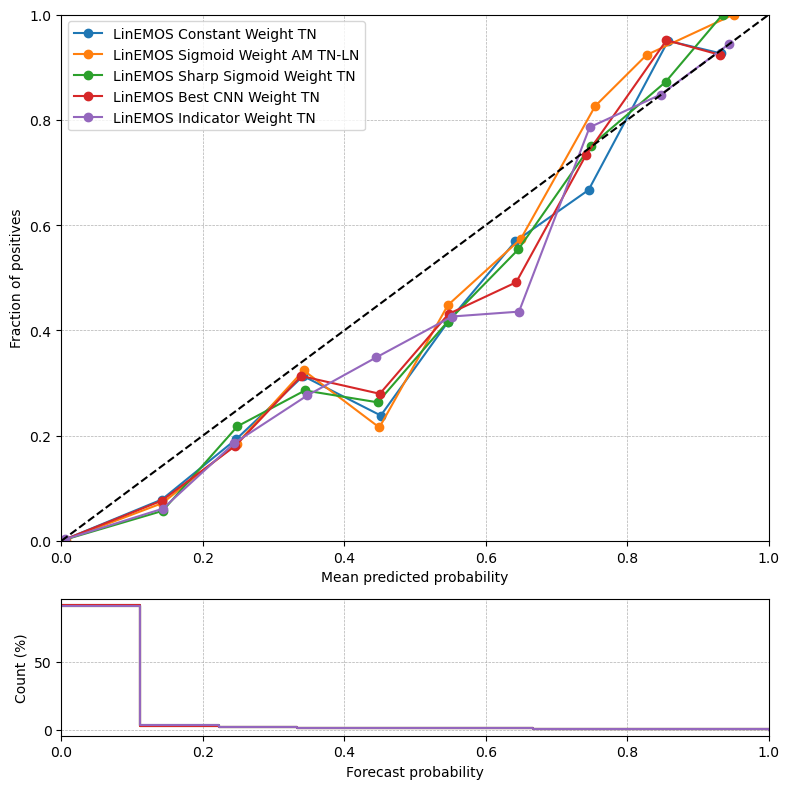

In [74]:
t = 12
make_reliability_and_sharpness(all_linear_models_fold0, test_data0, t=t)

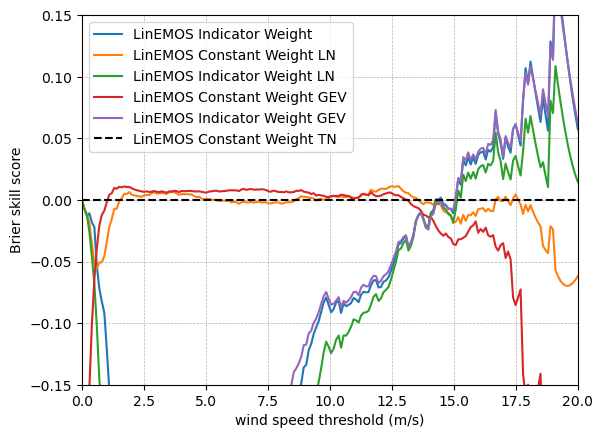

In [15]:
values = np.linspace(0,20,200)
ylim = [-0.15, 0.15]
make_brier_skill_plot(constant_weight_tn, linear_models_different_distribution, test_data0, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')

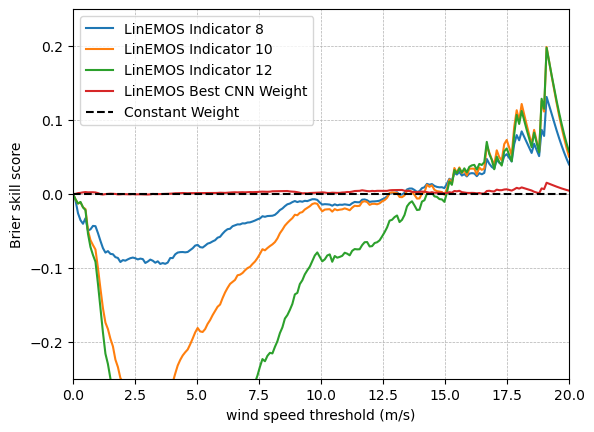

In [23]:
values = np.linspace(0,20,200)
ylim = [-0.25,0.25]
make_brier_skill_plot(constant_weight_tn, all_indicator_weight_models, test_data0, values, ylim=ylim, name_base_model='Constant Weight')

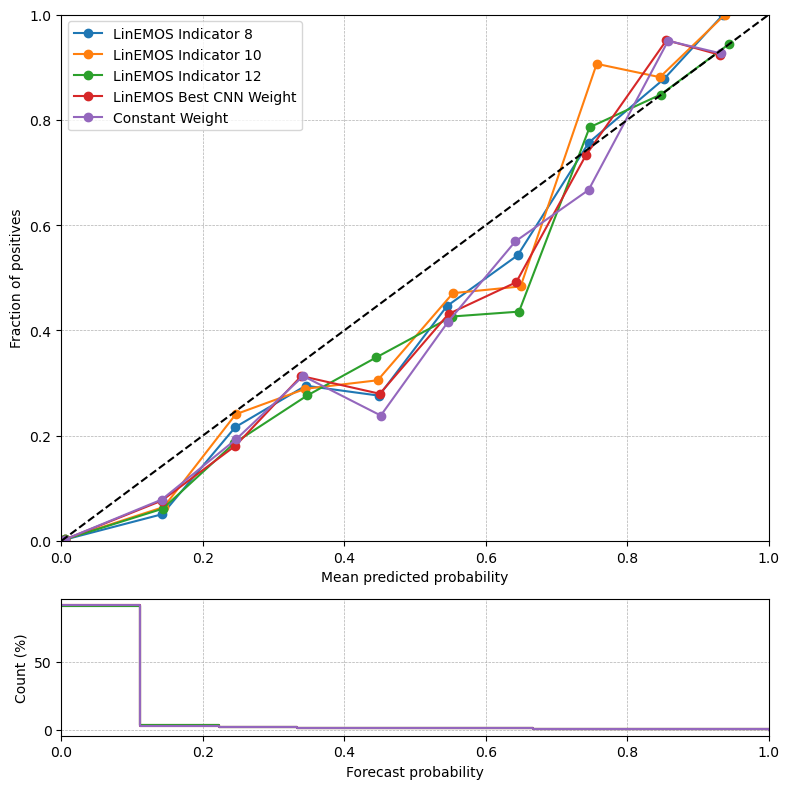

In [25]:
t = 12
make_reliability_and_sharpness(all_indicator_weight_models, test_data0, t=t, base_model=constant_weight_tn, base_model_name='Constant Weight')

### Results for Cross-Validation

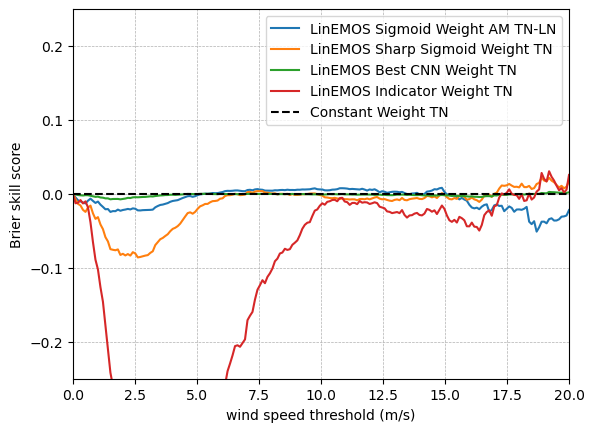

In [22]:
values = np.linspace(0,20,200)
ylim = [-0.25, 0.25]
make_brier_skill_plot(constant_weight_tn1, all_linear_models_without_constant_weight1, test_data1, values, ylim=ylim, name_base_model='Constant Weight TN')

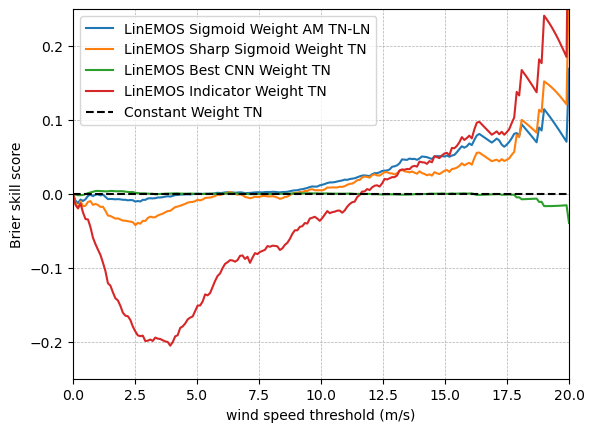

In [23]:
values = np.linspace(0,20,200)
ylim = [-0.25, 0.25]
make_brier_skill_plot(constant_weight_tn2, all_linear_models_without_constant_weight2, test_data2, values, ylim=ylim, name_base_model='Constant Weight TN')

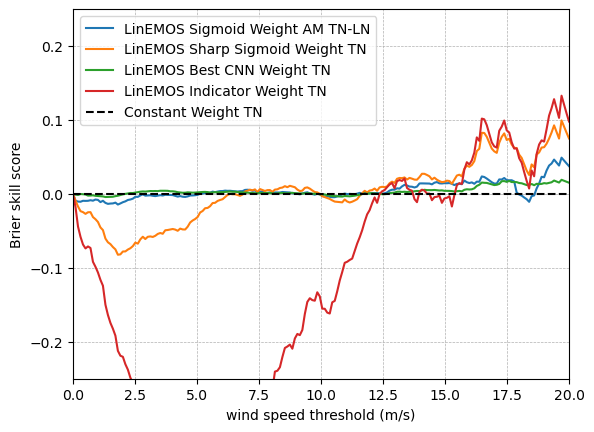

In [24]:
values = np.linspace(0,20,200)
ylim = [-0.25, 0.25]
make_brier_skill_plot(constant_weight_tn3, all_linear_models_without_constant_weight3, test_data3, values, ylim=ylim, name_base_model='Constant Weight TN')

### Results Single CNNEMOS

272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


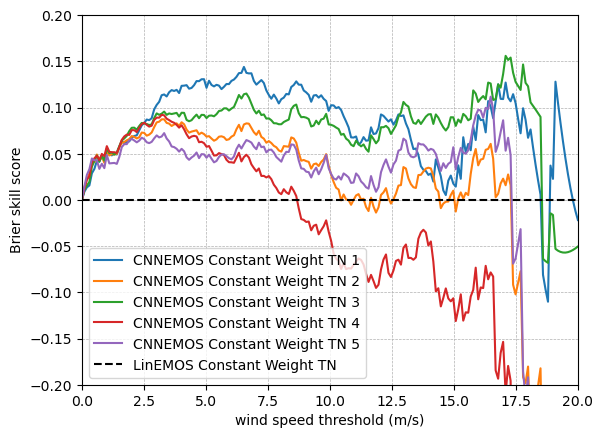

In [39]:
values = np.linspace(0,20,200)
ylim = [-0.2, 0.2]
make_brier_skill_plot(constant_weight_tn, single_cnn_constant_weight_dict, test_data0, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')

### Results Bagging

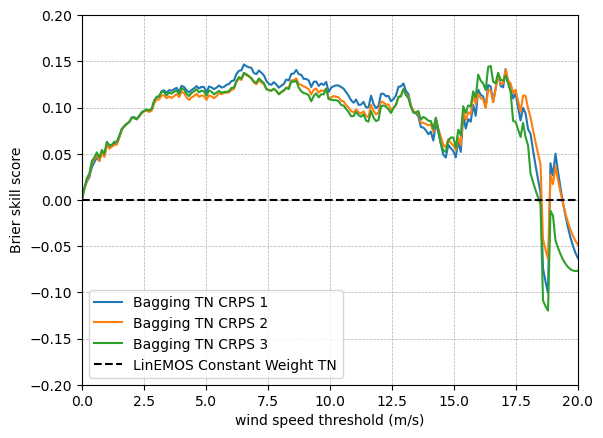

In [40]:
values = np.linspace(0,20,200)
ylim = [-0.2,0.2]
make_brier_skill_plot(constant_weight_tn, bagging_tn_crps_models, test_data0, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')     

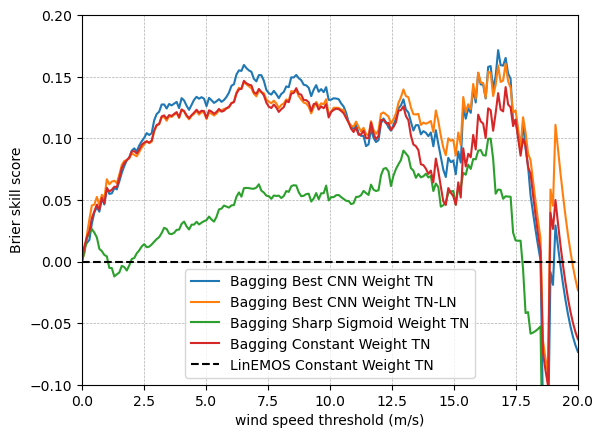

In [36]:
values = np.linspace(0,20,200)
ylim =[-0.1,0.2]
make_brier_skill_plot(constant_weight_tn, all_bagging_models, test_data0, values, ylim=ylim, name_base_model='LinEMOS Constant Weight TN')

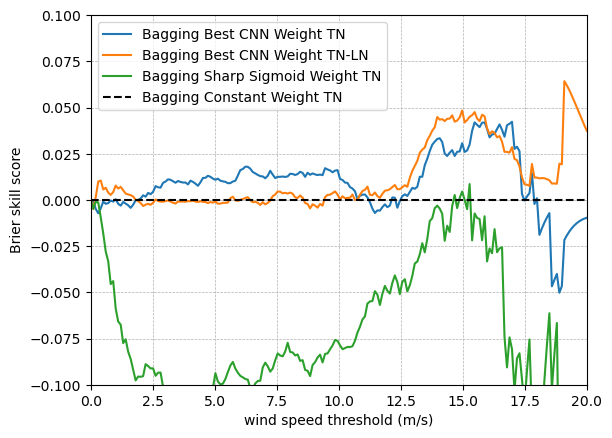

In [37]:
values = np.linspace(0,20,200)
ylim=[-0.1,0.1]
make_brier_skill_plot(bagging_tn_crps, all_bagging_models_without_constant_weight, test_data0, values=values, ylim=ylim, name_base_model='Bagging Constant Weight TN')

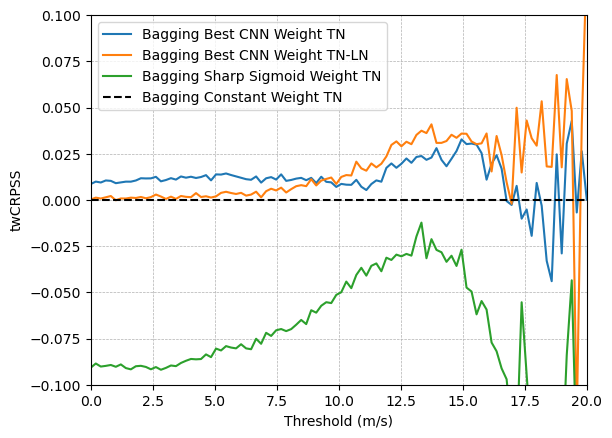

In [16]:
values = np.linspace(0,20,100)
ylim=[-0.1,0.1]
make_twcrpss_plot(bagging_tn_crps, all_bagging_models_without_constant_weight, test_data0, values, ylim=ylim, sample_size=200, base_model_name='Bagging Constant Weight TN')

There are 8671 values in the PIT diagram


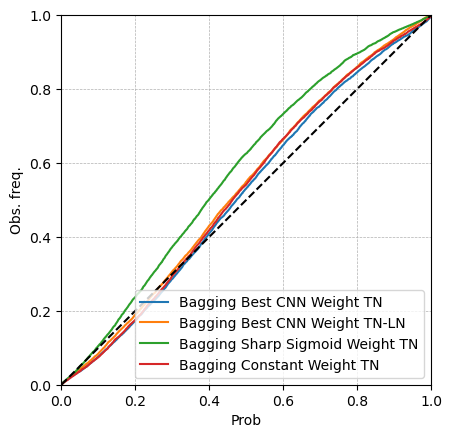

In [78]:
t = 0
make_cpit_diagram(all_bagging_models, test_data0_original, t=t)

There are 264 values in the PIT diagram


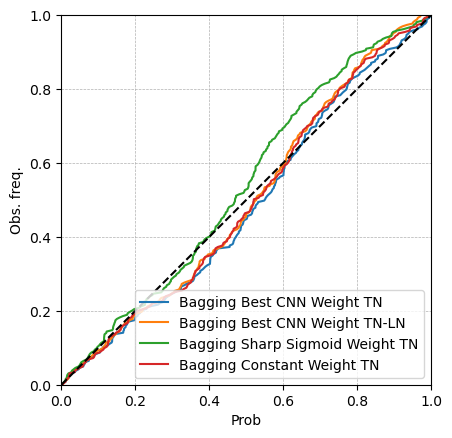

In [79]:
t = 12
make_cpit_diagram(all_bagging_models, test_data0_original, t=t)

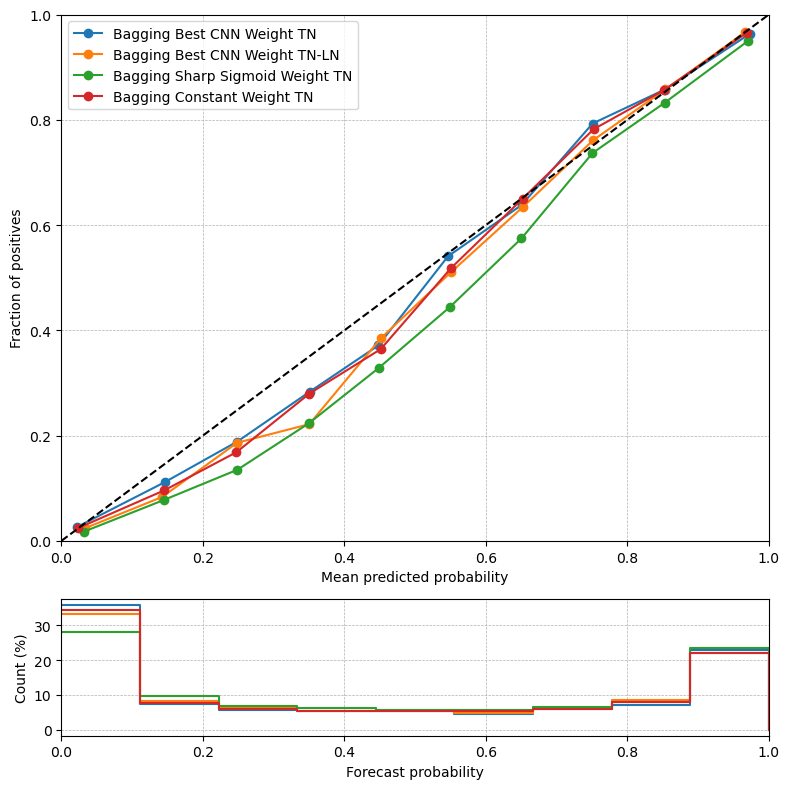

In [80]:
t = 5
make_reliability_and_sharpness(all_bagging_models, test_data0, t=t)

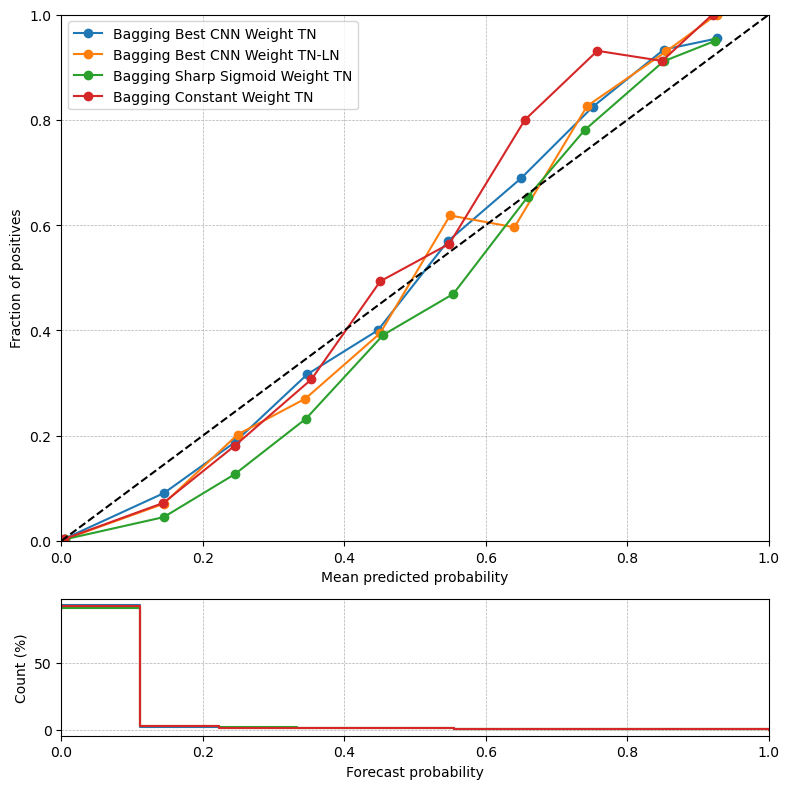

In [81]:
t = 12
make_reliability_and_sharpness(all_bagging_models, test_data0, t=t)

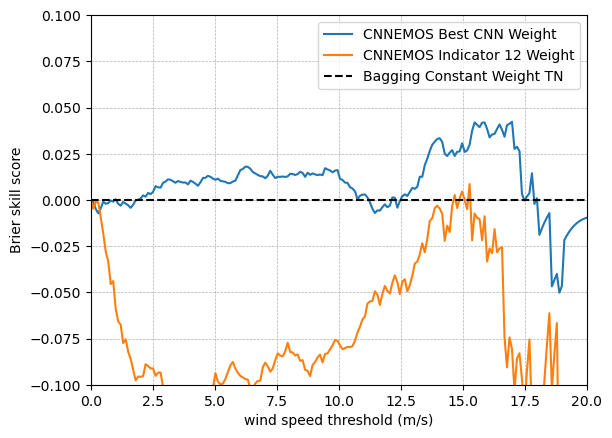

In [26]:
values = np.linspace(0,20,200)
ylim=[-0.1,0.1]
make_brier_skill_plot(bagging_tn_crps, bagging_models_science_talk, test_data0, values=values, ylim=ylim, name_base_model='Bagging Constant Weight TN')

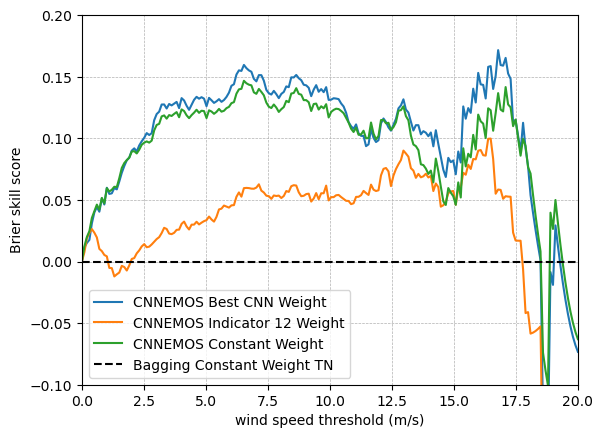

In [33]:
values = np.linspace(0,20,200)
ylim=[-0.1,0.2]
make_brier_skill_plot(constant_weight_tn, all_bagging_models_science_talk, test_data0, values=values, ylim=ylim, name_base_model='Bagging Constant Weight TN')

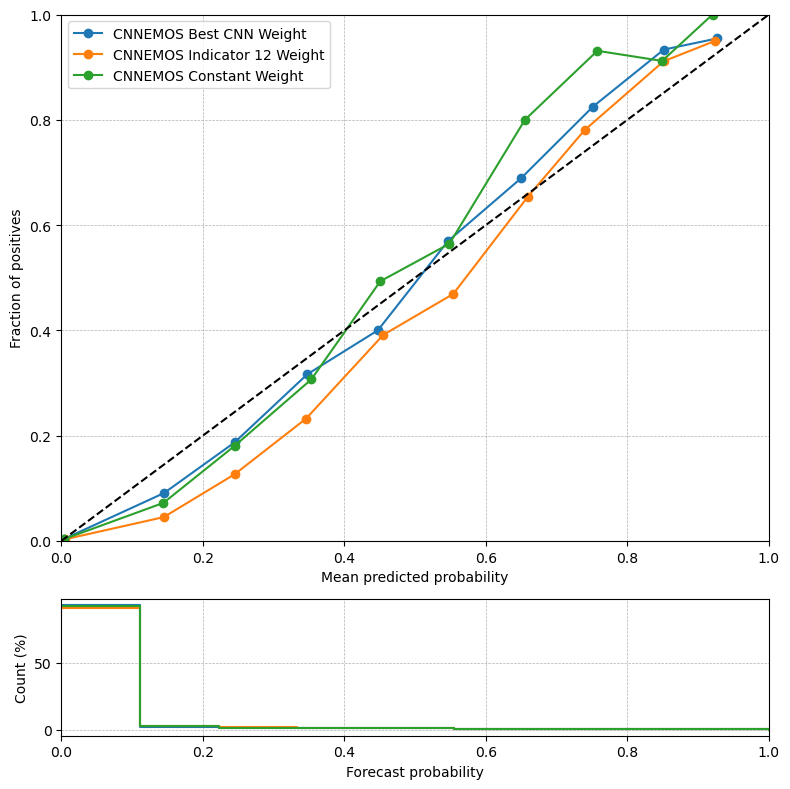

In [15]:
t = 12
make_reliability_and_sharpness(all_bagging_models_science_talk, test_data0, t=t)

### Bagging Cross-Validation

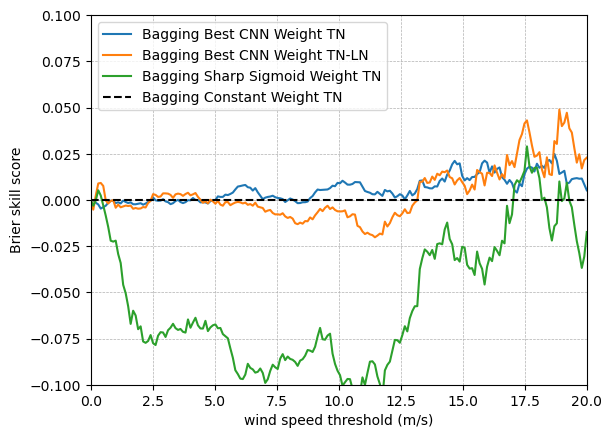

In [10]:
values = np.linspace(0,20,200)
ylim=[-0.1,0.1]
make_brier_skill_plot(bagging_tn_crps_f1, all_bagging_models_without_constant_weight_f1, test_data1, values=values, ylim=ylim, name_base_model='Bagging Constant Weight TN')

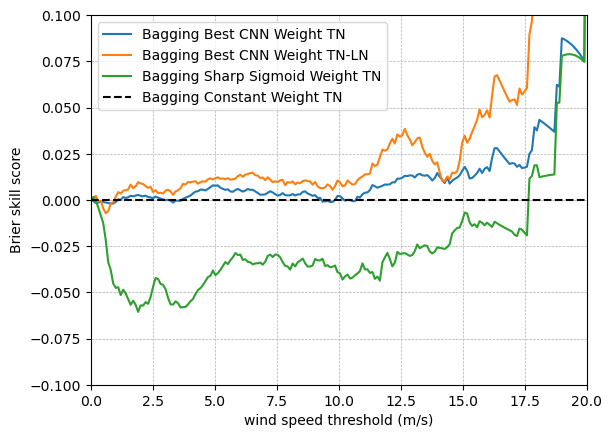

In [11]:
values = np.linspace(0,20,200)
ylim=[-0.1,0.1]
make_brier_skill_plot(bagging_tn_crps_f2, all_bagging_models_without_constant_weight_f2, test_data2, values=values, ylim=ylim, name_base_model='Bagging Constant Weight TN')

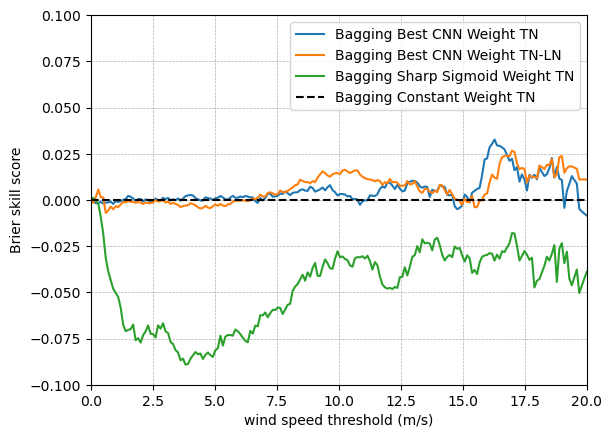

In [12]:
values = np.linspace(0,20,200)
ylim=[-0.1,0.1]
make_brier_skill_plot(bagging_tn_crps_f3, all_bagging_models_without_constant_weight_f3, test_data3, values=values, ylim=ylim, name_base_model='Bagging Constant Weight TN')

### Weigt of the Mixture CNNs

272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


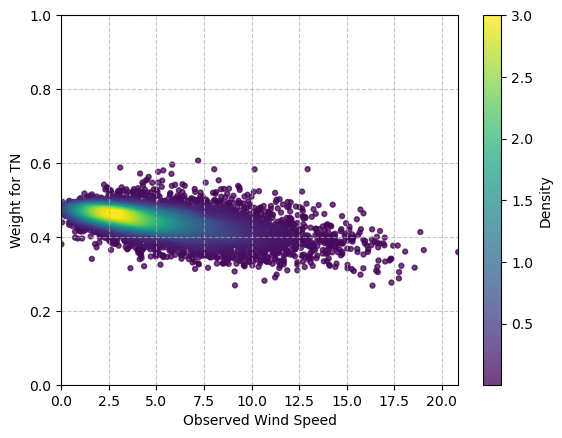

In [7]:
plot_weight_mixture_cnns(bagging_best_cnn_weight_tn_ln.models[5], test_data0)

272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


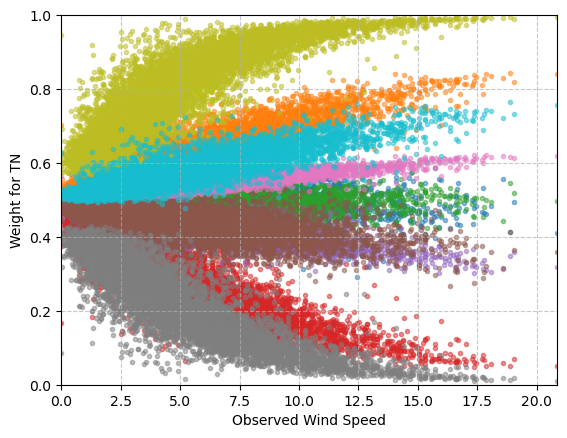

In [7]:
plot_weight_mixture_bagging(bagging_best_cnn_weight_tn_ln, test_data0, False)

### PDFs of Bagging models

In [19]:
X, y = next(iter(test_data0))

predictions = []

for model in bagging_tn_crps.models:
    predictions.append(model.predict(X))


272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [41]:
X_forecast = X['wind_speed_forecast']

In [20]:
sample_number = 10
distributions = []
for i, prediction in enumerate(predictions):
    distribution = bagging_tn_crps.models[i].get_distribution(prediction)
    distributions.append(distribution)

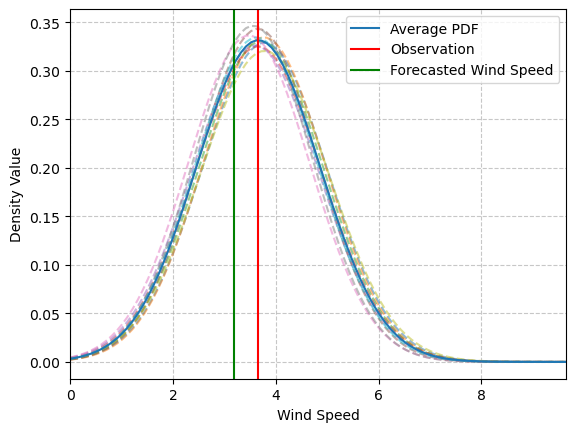

In [63]:
x = np.linspace(0,20,200)
value = 314
averages = np.zeros(shape=(10, 200))
for i, distribution in enumerate(distributions):
    distribution_values = distribution[value].prob(x)
    plt.plot(x, distribution_values, linestyle='--', alpha=0.5)
    averages[i,:] = distribution_values

plt.plot(x, averages.mean(axis=0), label='Average PDF')

plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Density Value')
plt.xlabel('Wind Speed')
plt.axvline(y[value], color = 'red', label = 'Observation')
plt.axvline(X_forecast[value], color='green', label='Forecasted Wind Speed')
xminval = np.max([0, y[value]-6])
plt.xlim(xminval, y[value] + 6)
plt.legend()
plt.show()


In [2]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

with open(filepath + 'epochs_sharp_sigmoid_tn', 'rb') as f:
    my_list = pickle.load(f)

In [3]:
print(np.mean(my_list))

74.56521739130434
